# Covid-19 Chest X-ray Detector

Try to detect Covid-19 from X-rays, the datasets belongs to [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset) and [chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

There is 2 sources from X-rays because the first one have only X-rays with pathologies, and the second one contain  normal X-rays (an others pathologies, but we will use only the normal x-rays).

**Processing dataset**
 * Get Posteroanterior x-ray images. 
 * Keep only the fields 'finding', 'folder' and 'filename'
 * Change folder columns with the complete local path
 * Define the value to predict in setting "covid-19" and "covid-19, ARDS" field as true. The other will be set as false
 * Add new x-ray images to complete dataset
 * Split data into train, test, predict and copy them to a specific directory structure.

In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

Using TensorFlow backend.
/home/psa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/psa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/psa/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/psa/.local/lib/python3.7/site-packages/tensorflow/python/framework/d

In [2]:
# Global defnitions
chestxray_images_folder = '../covid-chestxray-dataset'
chestxray_normal_folder = '../chest_xray/train/NORMAL'

In [3]:
# Load data from covid-chestxray-dataset and display 5 first rows
raw_data = pd.read_csv(os.path.join(chestxray_images_folder,'metadata.csv'))
raw_data.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


## Prepare dataset
To have a omogenous dataset we will keep only from back to front (Posteroanterior) X-rays. Because we are trying to predict covid from X-ray images, we wil keep only the fields 'finding', 'folder' and 'filename'. We also need to set the correct path for the images.

In [4]:
#  Get only Posteroanterior X-rays 
chestxrays = raw_data[(raw_data['modality'] == 'X-ray') & (raw_data['view'] == 'PA')]

In [5]:
# keep 'finding', 'folder' and 'filename'
col_to_drop = ['patientid', 'offset', 'sex', 'age', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28']

chestxrays = chestxrays.drop(col_to_drop, axis=1)

In [6]:
# Set correct path according to local installation
chestxrays['filename'] = chestxrays.apply(lambda x : os.path.join(chestxray_images_folder,x.folder,x.filename),axis=1)
chestxrays.drop('folder', axis=1, inplace=True)

In [7]:
chestxrays.head()

,finding,filename
0,COVID-19,../covid-chestxray-dataset/images/auntminnie-a...
1,COVID-19,../covid-chestxray-dataset/images/auntminnie-b...
2,COVID-19,../covid-chestxray-dataset/images/auntminnie-c...
3,COVID-19,../covid-chestxray-dataset/images/auntminnie-d...
4,COVID-19,../covid-chestxray-dataset/images/nejmc2001573...


## Define value to predict
When need to predict covid or not covid
change all 'finding' equal to 'COVID-19' to 1 and the others to 0 in a new col 'covid-19'


In [8]:
chestxrays["finding"].value_counts()

COVID-19          141
Streptococcus      13
Pneumocystis       12
COVID-19, ARDS     11
SARS                8
ARDS                4
Legionella          2
No Finding          2
Chlamydophila       1
Klebsiella          1
Name: finding, dtype: int64

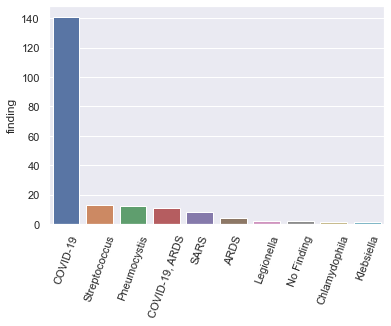

In [9]:
sns.barplot(x=chestxrays["finding"].value_counts().index, y=chestxrays["finding"].value_counts())
plt.xticks(rotation=70)
plt.show()

In [10]:
# add new column 'covid-19' and drop 'finding'
# set 1 for COVID-19 and COVID-19, ARDS and 0 for others values 
chestxrays['covid-19'] = chestxrays['finding'].map(lambda x:1 if (x == 'COVID-19' or x == 'COVID-19, ARDS') else 0)
chestxrays = chestxrays.drop(['finding'], axis=1)

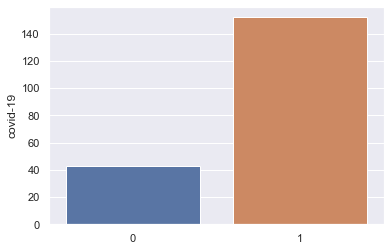

In [11]:
sns.barplot(x=chestxrays["covid-19"].value_counts().index, y=chestxrays["covid-19"].value_counts())
plt.show()

In [12]:
chestxrays["covid-19"].value_counts()

1    152
0     43
Name: covid-19, dtype: int64

In [13]:
chestxrays.head()

,filename,covid-19
0,../covid-chestxray-dataset/images/auntminnie-a...,1
1,../covid-chestxray-dataset/images/auntminnie-b...,1
2,../covid-chestxray-dataset/images/auntminnie-c...,1
3,../covid-chestxray-dataset/images/auntminnie-d...,1
4,../covid-chestxray-dataset/images/nejmc2001573...,1


In [14]:
def display_random_images(df, nb_images):
    """Display x random images from dataset
    """
    random_index = [np.random.choice(df.index) for i in range(nb_images)]        
    plt.figure(figsize=(20,10))
    for i in range(nb_images):        
        image = df.iloc[i]['filename']     
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image)
        plt.imshow(img, cmap='gray')
        plt.axis('off')    
    plt.tight_layout()  

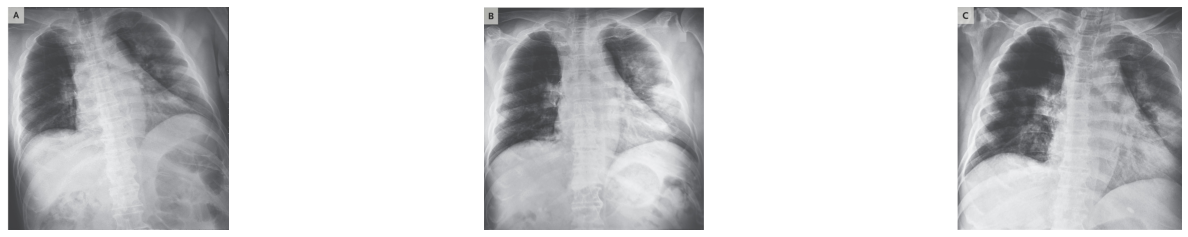

In [15]:
display_random_images(chestxrays, 3)

## Add new dataset
Add more non-covid chest X-rays from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia in directory train/NORMAL

In [16]:
nb_images_to_add = chestxrays["covid-19"].value_counts()[1] - chestxrays["covid-19"].value_counts()[0]
print(f"Number of normal images to add {nb_images_to_add}")

Number of normal images to add 109


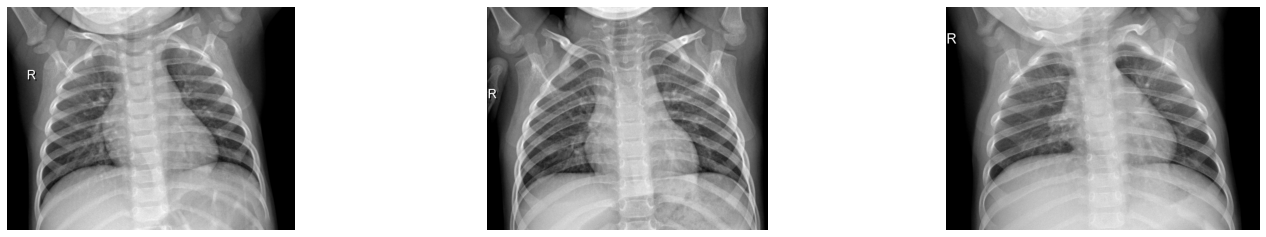

In [17]:
images = []
files = os.listdir(chestxray_normal_folder)
for name in files:
    images.append(name)
    
# Select randomly X images and add to new dataset
random_images = [np.random.choice(images) for i in range(nb_images_to_add)]    
column_names = ["filename","covid-19"]
chests = pd.DataFrame(columns = column_names)

for image in random_images:
    new_row = pd.Series(data={'filename': os.path.join(chestxray_normal_folder,image), 'covid-19':0})
    chests = chests.append(new_row, ignore_index=True)

    
display_random_images(chests, 3)

## Organize data

In [18]:
# Merge thge datasets
chestxrays = pd.concat([chestxrays, chests])

In [19]:
chestxrays["covid-19"].value_counts()

1    152
0    152
Name: covid-19, dtype: int64

In [20]:
# Save as CSV
chestxrays.to_csv('data/chestxrays.csv', index=False)

In [21]:
import shutil
import os.path 

In [22]:
def cleanDestination(destination):
    """Delete folder and subdirectories
    """
    try:
        shutil.rmtree(destination)
    except OSError:
        pass

In [23]:
def copyData(source, destination, new_filename=""):
    """
    Copy file to specified directory. Create destination directory if needed
    """
    try :
        os.makedirs(destination)
    except OSError:
        pass
    
    if new_filename:
        destination = os.path.join(destination,new_filename)   
    else:
        destination = os.path.join(destination,os.path.basename(source))   
        
    shutil.copyfile(source, destination)       
        

In [24]:
# Split data into train, test and predict directories
train_dir = 'data/train/'
test_dir  = 'data/test/'
pred_dir  = 'data/predict/'

cleanDestination(train_dir)
cleanDestination(test_dir) 
cleanDestination(pred_dir) 
    
train_test,predict = train_test_split(chestxrays, test_size=0.1, random_state=42)
train, test = train_test_split(train_test, test_size=0.2, random_state=42)

# Predict data
for index, row in predict.iterrows():
    filename = str(row['covid-19']) + '-' + os.path.basename(row['filename'])
    copyData(row['filename'], pred_dir, filename )
    
# Train data
for index, row in train.iterrows():
    destination = train_dir + '0_normal'
    if row['covid-19'] == 1:
        destination = train_dir +  '1_covid'
    copyData(row['filename'], destination)

# Test data
for index, row in test.iterrows():
    destination = test_dir + '0_normal'
    if row['covid-19'] == 1:
        destination = test_dir + '1_covid'
    copyData(row['filename'], destination)
